In [1]:
import os
import json
import numpy as np
import pandas as pd
from joblib import load, dump
import matplotlib.pyplot as plt
# from art.estimators.classification import BlackBoxClassifier
# from art.attacks.evasion import HopSkipJump
# from art.attacks.evasion import BoundaryAttack
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

In [2]:
base_dir = r"D:\Path\to\the\directory\where\the\extracted_mimic_iii_data\is\stored"

Loading Artifacts und defining Bounds

In [3]:
train_csv = os.path.join(base_dir, "CLEAN", "train_clean.csv")
test_csv  = os.path.join(base_dir, "CLEAN", "test_clean.csv")
meta_json = os.path.join(base_dir, "CLEAN", "preprocess_metadata.json")

In [4]:
train = pd.read_csv(train_csv)
test  = pd.read_csv(test_csv)
with open(meta_json, "r") as f:
    meta = json.load(f)

label_col = meta["label_col"]
num_cols  = meta["num_cols"]
cat_cols  = meta["cat_cols"]

In [5]:
# Load saved models
pipe_xgb = load(os.path.join(base_dir, "models", "xgb_pipeline.joblib"))
pipe_lr  = load(os.path.join(base_dir, "models", "lr_pipeline.joblib"))

In [6]:
# Per-feature numeric bounds from TRAIN
# min/max bounds to ensure adversarial values don't go out of range
num_bounds = {c: (float(train[c].min()), float(train[c].max())) for c in num_cols}

In [7]:
# Testing with 15000 samples (4000 positve and 11000 negative)
# Testing with 1500 samples (400 positve and 1100 negative)
pos = test[test[label_col]==1].sample(n=min(4000, (test[label_col]==1).sum()), random_state=42)
neg = test[test[label_col]==0].sample(n=min(11000, (test[label_col]==0).sum()), random_state=42)
batch = pd.concat([pos, neg], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
# Full dataset (shuffled)
# Too large, tends to overload memory (49294 rows)
# batch = test.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
X_num_batch = batch[num_cols].copy().reset_index(drop=True)
X_cat_batch = batch[cat_cols].copy().reset_index(drop=True).astype("category")
y_batch     = batch[label_col].astype(int).values

ART black-box wrappers

In [10]:
# Helper to clip numeric features to training bounds
def clip_to_bounds(X_num_nd):
    X = np.array(X_num_nd, dtype=np.float32).copy()
    for j, col in enumerate(num_cols):
        lo, hi = num_bounds[col]
        X[:, j] = np.clip(X[:, j], lo, hi)
    return X

In [11]:
def summarize(name, p_clean, p_adv, y_true, thr):
    from sklearn.metrics import classification_report, confusion_matrix
    import numpy as np
    def metrics(p):
        return {
            "roc_auc": roc_auc_score(y_true, p),
            "pr_auc":  average_precision_score(y_true, p),
            "f1@thr":  f1_score(y_true, (p>=thr).astype(int))
        }
    m0 = metrics(p_clean)
    m1 = metrics(p_adv)
    print(f"\n=== {name} ===")
    print("Clean :", m0)
    print("Adv   :", m1)
    drop_roc = m0["roc_auc"] - m1["roc_auc"]
    drop_pr  = m0["pr_auc"]  - m1["pr_auc"]
    print(f"Δ ROC AUC: {drop_roc:.3f}  Δ PR AUC: {drop_pr:.3f}")
    # report at the tuned threshold
    print("\nClassification report (adv) at tuned threshold:")
    print(classification_report(y_true, (p_adv>=thr).astype(int), digits=3))
    print("Confusion matrix (adv):")
    print(confusion_matrix(y_true, (p_adv>=thr).astype(int)))

In [12]:
# Tuned thresholds
tau_lr  = 0.661
tau_xgb = 0.712

-----------------------------------------------
Attack #1 FGSM (Fast Gradient Sign Method)

In [13]:
# ===== FGSM helpers =====
art_dir = os.path.join(base_dir, "ART"); os.makedirs(art_dir, exist_ok=True)

In [14]:
# Quantile bounds from TRAIN for realistic clinical ranges
q_low, q_high = 0.005, 0.995
lo_arr = train[num_cols].quantile(q_low).astype(float).values
hi_arr = train[num_cols].quantile(q_high).astype(float).values

In [15]:
# Standart deviation scale, avoid division by 0
train_std = train[num_cols].std().replace(0, 1.0).astype(float).values

In [16]:
def _build_df_row(x_num_row, cats_row):
    """Create a one-row DataFrame for pipeline.predict_proba."""
    return pd.concat(
        [pd.DataFrame([x_num_row], columns=num_cols),
         cats_row.reset_index(drop=True)],
        axis=1
    )

def pipeline_proba_batch(pipeline, X_num, X_cat):
    """Predict p(y=1) for a numeric matrix and matching categorical rows."""
    df = pd.concat(
        [pd.DataFrame(X_num, columns=num_cols),
         X_cat.reset_index(drop=True).iloc[:len(X_num)]],
        axis=1
    )
    return pipeline.predict_proba(df)[:, 1]

In [17]:
def finite_diff_grad(pipeline, x, cats_row, h_scale=0.01):
    """
    Numerical gradient of p(y=1|x) w.r.t. numeric features using central differences.
    h_j = h_scale * std_j  (clinical scale-aware).
    Returns dp/dx as a 1D array.
    """
    d = len(x)
    dpdx = np.zeros(d, dtype=np.float32)
    for j in range(d):
        h = max(h_scale * float(train_std[j]), 1e-6)
        x_plus  = x.copy(); x_plus[j]  = np.clip(x_plus[j]  + h, lo_arr[j], hi_arr[j])
        x_minus = x.copy(); x_minus[j] = np.clip(x_minus[j] - h, lo_arr[j], hi_arr[j])
        p_plus  = pipeline.predict_proba(_build_df_row(x_plus,  cats_row))[0, 1]
        p_minus = pipeline.predict_proba(_build_df_row(x_minus, cats_row))[0, 1]
        dpdx[j] = (p_plus - p_minus) / (2.0 * h)
    return dpdx

In [18]:
# FGSM for tabular
# Numeric-only perturbations, categoricals fixed

def fgsm_numeric(pipeline, X_num, X_cat, y, eps=0.10, h_scale=0.01):
    """
    White-box FGSM step using finite-difference gradients.
    - Untargeted (increase CE loss).
    - Only numeric features are perturbed.
    - Clipped to quantile box [lo_arr, hi_arr].
    """
    X_num = np.array(X_num, dtype=np.float32)
    X_adv = X_num.copy()
    for i in range(X_num.shape[0]):
        x  = X_num[i].copy()
        cr = X_cat.iloc[i:i+1]
        # base prob and CE derivative w.r.t. p
        p = pipeline.predict_proba(_build_df_row(x, cr))[0, 1]
        y_i = int(y[i])
        # for binary cross-entropy
        dLdp = - (y_i / (p + 1e-8)) + ((1 - y_i) / (1 - p + 1e-8))
        # numerical dp/dx
        g = finite_diff_grad(pipeline, x, cr, h_scale=h_scale)
        grad = dLdp * g
        # FGSM update and clip
        x_adv = x + eps * np.sign(grad)
        X_adv[i] = np.minimum(np.maximum(x_adv, lo_arr), hi_arr)
    return X_adv

In [19]:
# Baseline probs batch using pipelines
Xn = X_num_batch.values.astype(np.float32)
p0_xgb_pipe = pipeline_proba_batch(pipe_xgb, Xn, X_cat_batch)
p0_lr_pipe  = pipeline_proba_batch(pipe_lr,  Xn, X_cat_batch)

# eps and h_scale
eps = 0.10
h_scale = 0.01

In [20]:
# Generate FGSM adversarials
X_fgsm_xgb = fgsm_numeric(pipe_xgb, Xn, X_cat_batch, y_batch, eps=eps, h_scale=h_scale)

In [21]:
X_fgsm_lr  = fgsm_numeric(pipe_lr,  Xn, X_cat_batch, y_batch, eps=eps, h_scale=h_scale)

In [22]:
# Probabilities on attacked inputs
p_fgsm_xgb = pipeline_proba_batch(pipe_xgb, X_fgsm_xgb, X_cat_batch)
p_fgsm_lr  = pipeline_proba_batch(pipe_lr,  X_fgsm_lr,  X_cat_batch)

In [23]:
# Summary
summarize(f"XGBoost + FGSM (eps={eps})", p0_xgb_pipe, p_fgsm_xgb, y_batch, tau_xgb)


=== XGBoost + FGSM (eps=0.1) ===
Clean : {'roc_auc': 0.8631857036195516, 'pr_auc': 0.5216988877893726, 'f1@thr': 0.4692058346839546}
Adv   : {'roc_auc': 0.7790951443189083, 'pr_auc': 0.3837643701697686, 'f1@thr': 0.35272184936614465}
Δ ROC AUC: 0.084  Δ PR AUC: 0.138

Classification report (adv) at tuned threshold:
              precision    recall  f1-score   support

           0      0.926     0.915     0.920     10965
           1      0.336     0.371     0.353      1274

    accuracy                          0.858     12239
   macro avg      0.631     0.643     0.637     12239
weighted avg      0.865     0.858     0.861     12239

Confusion matrix (adv):
[[10030   935]
 [  801   473]]


In [24]:
summarize(f"LogReg  + FGSM (eps={eps})", p0_lr_pipe,  p_fgsm_lr, y_batch,  tau_lr)


=== LogReg  + FGSM (eps=0.1) ===
Clean : {'roc_auc': 0.8046300452202347, 'pr_auc': 0.3624203634192398, 'f1@thr': 0.39465308720560155}
Adv   : {'roc_auc': 0.5596031614792607, 'pr_auc': 0.13618073989506846, 'f1@thr': 0.17741935483870966}
Δ ROC AUC: 0.245  Δ PR AUC: 0.226

Classification report (adv) at tuned threshold:
              precision    recall  f1-score   support

           0      0.903     0.755     0.823     10965
           1      0.126     0.302     0.177      1274

    accuracy                          0.708     12239
   macro avg      0.514     0.529     0.500     12239
weighted avg      0.822     0.708     0.756     12239

Confusion matrix (adv):
[[8284 2681]
 [ 889  385]]


In [25]:
os.makedirs(os.path.join(base_dir, "adv_models"), exist_ok=True)

In [ ]:
dump(X_fgsm_xgb, os.path.join(base_dir, "adv_models", "X_fgsm_xgb_15000.joblib"))

In [ ]:
dump(p_fgsm_xgb, os.path.join(base_dir, "adv_models", "p_fgsm_xgb_15000.joblib"))

In [ ]:
dump(X_fgsm_lr, os.path.join(base_dir, "adv_models", "X_fgsm_lr_15000.joblib"))

In [ ]:
dump(p_fgsm_lr, os.path.join(base_dir, "adv_models", "p_fgsm_lr_15000.joblib"))

In [ ]:
dump(p0_xgb_pipe, os.path.join(base_dir, "adv_models", "p0_xgb_pipe_15000.joblib"))
dump(p0_lr_pipe, os.path.join(base_dir, "adv_models", "p0_lr_pipe_15000.joblib"))
dump(y_batch, os.path.join(base_dir, "adv_models", "y_batch_15000.joblib"))
dump(tau_xgb, os.path.join(base_dir, "adv_models", "tau_xgb_15000.joblib"))
dump(tau_lr, os.path.join(base_dir, "adv_models", "tau_lr_15000.joblib"))

In [ ]:
dump(X_num_batch, os.path.join(base_dir, "adv_models", "X_num_batch_15000.joblib"))
dump(X_cat_batch, os.path.join(base_dir, "adv_models", "X_cat_batch_15000.joblib"))

Sweeps at different Epsilons

In [46]:
# Small sweep batch (1500 samples)
def make_small_batch(test_df, label_col, n_pos=400, n_neg=1100, seed=123):
    pos = test_df[test_df[label_col]==1].sample(n=min(n_pos, (test_df[label_col]==1).sum()), random_state=seed)
    neg = test_df[test_df[label_col]==0].sample(n=min(n_neg, (test_df[label_col]==0).sum()), random_state=seed)
    return pd.concat([pos, neg], axis=0).sample(frac=1, random_state=seed).reset_index(drop=True)

In [47]:
sweep_batch = make_small_batch(test, label_col, n_pos=400, n_neg=1100, seed=123)
Xn_sweep = sweep_batch[num_cols].to_numpy(np.float32)
Xc_sweep = sweep_batch[cat_cols].reset_index(drop=True).astype("category")
y_sweep = sweep_batch[label_col].to_numpy(np.int32)

In [48]:
# Summary row Model + Eps
def add_row(model, eps, p_clean, p_adv, tau=None, recompute_tau=False):
    """
    model: 'XGB+FGSM' or 'LR+FGSM'
    eps:   FGSM epsilon
    p_clean, p_adv: probabilities on the SAME sweep batch (length == len(y_sweep))
    tau:   decision threshold to use; if None or recompute_tau=True, match the batch prevalence
    """
    if recompute_tau or (tau is None):
        tau = np.quantile(p_clean, 1 - y_sweep.mean())

    clean_roc = roc_auc_score(y_sweep, p_clean)
    adv_roc   = roc_auc_score(y_sweep, p_adv)
    clean_pr  = average_precision_score(y_sweep, p_clean)
    adv_pr    = average_precision_score(y_sweep, p_adv)

    return {
        "model":        model,
        "eps":          float(eps),
        "clean_roc":    clean_roc,
        "adv_roc":      adv_roc,
        "delta_roc":    float(clean_roc - adv_roc),
        "clean_pr":     clean_pr,
        "adv_pr":       adv_pr,
        "delta_pr":     float(clean_pr - adv_pr),
        "f1_clean@thr": f1_score(y_sweep, (p_clean >= tau).astype(int)),
        "f1_adv@thr":   f1_score(y_sweep, (p_adv   >= tau).astype(int)),
    }

In [49]:
# Baseline probs for the sweep batch
p0_xgb_sweep = pipeline_proba_batch(pipe_xgb, Xn_sweep, Xc_sweep)
p0_lr_sweep = pipeline_proba_batch(pipe_lr,  Xn_sweep, Xc_sweep)

In [50]:
# sweep
rows = []
for eps in [0.02, 0.05, 0.10, 0.20]:
    # XGB
    X_fgsm_xgb_s = fgsm_numeric(pipe_xgb, Xn_sweep, Xc_sweep, y_sweep, eps=eps, h_scale=0.01)
    p_fgsm_xgb_s = pipeline_proba_batch(pipe_xgb, X_fgsm_xgb_s, Xc_sweep)
    rows.append(add_row("XGB+FGSM", eps, p0_xgb_sweep, p_fgsm_xgb_s, tau_xgb))

    # LR
    X_fgsm_lr_s  = fgsm_numeric(pipe_lr,  Xn_sweep, Xc_sweep, y_sweep, eps=eps, h_scale=0.01)
    p_fgsm_lr_s  = pipeline_proba_batch(pipe_lr,  X_fgsm_lr_s,  Xc_sweep)
    rows.append(add_row("LR+FGSM",  eps, p0_lr_sweep,  p_fgsm_lr_s,  tau_lr))

In [51]:
fgsm_summary = pd.DataFrame(rows).sort_values(["model","eps"]).reset_index(drop=True)
fgsm_summary.to_csv(os.path.join(art_dir, "fgsm_sweep_summary_small.csv"), index=False)
display(fgsm_summary)

,model,eps,clean_roc,adv_roc,delta_roc,clean_pr,adv_pr,delta_pr,f1_clean@thr,f1_adv@thr
0,LR+FGSM,0.02,0.812661,0.769182,0.043480,0.617471,0.551906,0.065566,0.548747,0.493689
1,LR+FGSM,0.05,0.812661,0.695648,0.117014,0.617471,0.455746,0.161725,0.548747,0.405995
2,LR+FGSM,0.10,0.812661,0.560241,0.252420,0.617471,0.321628,0.295843,0.548747,0.301158
3,LR+FGSM,0.20,0.812661,0.308959,0.503702,0.617471,0.190285,0.427186,0.548747,0.130621
4,XGB+FGSM,0.02,0.869355,0.816457,0.052898,0.740726,0.649023,0.091703,0.569207,0.472843
5,XGB+FGSM,0.05,0.869355,0.812341,0.057014,0.740726,0.643409,0.097316,0.569207,0.473600
6,XGB+FGSM,0.10,0.869355,0.787475,0.081880,0.740726,0.609870,0.130855,0.569207,0.459627
7,XGB+FGSM,0.20,0.869355,0.737830,0.131525,0.740726,0.552765,0.187960,0.569207,0.425406


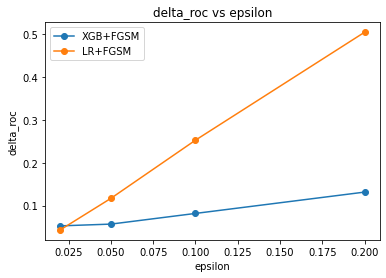

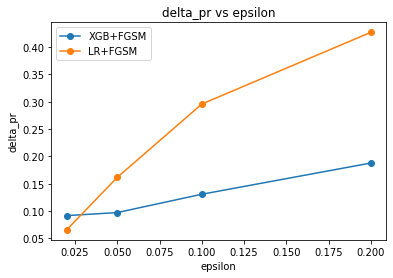

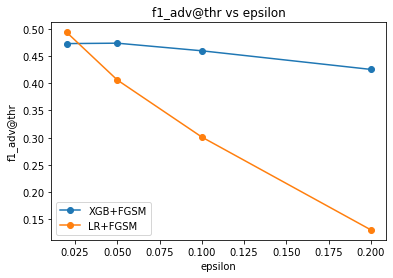

In [53]:
for metric in ["delta_roc", "delta_pr", "f1_adv@thr"]:
    plt.figure()
    for mdl in ["XGB+FGSM", "LR+FGSM"]:
        dfm = fgsm_summary[fgsm_summary["model"] == mdl]
        x = dfm["eps"].to_numpy(dtype=float)
        y = dfm[metric].to_numpy(dtype=float)
        plt.plot(x, y, marker="o", label=mdl)
    plt.xlabel("epsilon")
    plt.ylabel(metric)
    plt.title(f"{metric} vs epsilon")
    plt.legend()
    plt.show()